# Test implementation QRNN

Notebook based on this paper:

Quantum Recurrent Neural Networks for Sequential Learning ==> https://arxiv.org/pdf/2302.03244.pdf

In this implementation:
- We are using ancilla qubits to 'reinitialize' some qubits to 0
- We use Word2Vec to encode words to vector of size 25
- We also use a Linear Layer before our QRNN going from 25 to n_qubits_D

In [11]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader

# Pennylane
import pennylane as qml
from pennylane import numpy as np


# Plotting
import matplotlib.pyplot as plt

In [12]:
def seed_everything(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    torch.mps.manual_seed(seed)

In [13]:
seed_everything(0)

## Dataset loading

The dataset comes from the lambeq github. 

https://github.com/CQCL/lambeq/tree/main/docs/examples/datasets

'The goal is to classify simple sentences (such as “skillful programmer creates software” and “chef prepares delicious meal”) into two categories, food or IT. The dataset consists of 130 sentences created using a simple context-free grammar.'

In [14]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = float(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences


train_labels, train_data = read_data('../../../../../../../../Downloads/quantum_data/mc_train_data.txt')
dev_labels, dev_data = read_data('../../../../../../../../Downloads/quantum_data/mc_dev_data.txt')
test_labels, test_data = read_data('../../../../../../../../Downloads/quantum_data/mc_test_data.txt')

In [15]:
# From one-hot to integer
train_labels = np.argmax(train_labels, 1)
dev_labels = np.argmax(dev_labels, 1)
test_labels = np.argmax(test_labels, 1)

## Word2vec

In [16]:
import gensim.downloader

# Load the model from gensim-data
glove_model = gensim.downloader.load('glove-twitter-25')


In [17]:
#Get the word embeddings for each word in the sentence
def get_word_embeddings(sentence, seq_length):
    embeddings = []
    for word in sentence.split():
        try:
            embeddings.append(glove_model[word])
        except:
            pass

    #Pad the array with zeros if the sentence is shorter than the max length
    if len(embeddings) < seq_length:
        embeddings.extend(np.zeros((seq_length-len(embeddings), 25)))
    return np.array(embeddings)

In [18]:
def preprocess_dataset(data, seq_length):
    new_data = []
    for sentence in data:
        new_data.append(get_word_embeddings(sentence, seq_length))
    return np.array(new_data)

In [19]:
# Function to find the maximum length of each sentence in the dataset
def find_max_length(data):
    max_length = 0
    for sentence in data:
        if len(sentence.split()) > max_length:
            max_length = len(sentence.split())
    return max_length

In [20]:
# Compute the max length of the sentences
# This will allow us to pad the sentences to the same length
# + to know the number of qubits we need
seq_length = np.max([find_max_length(train_data), find_max_length(dev_data), find_max_length(test_data)])

In [21]:
X_train = preprocess_dataset(train_data, seq_length)
X_dev = preprocess_dataset(dev_data, seq_length)
X_test = preprocess_dataset(test_data, seq_length)

In [22]:
class EmbeddingDataset(Dataset):
    """Embedding dataset."""

    def __init__(self, X, Y):
        self.X = X
        self.Y = Y


    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        return torch.tensor(self.X[idx]).to(torch.float32) , torch.tensor(self.Y[idx]).to(torch.float32)

## Setting of the main hyper-parameters of the model

### To implement this circuit, we need ancilla qubits. 
For the Reg_D part we need X*max_sentence_len qubits and for the Reg_H part we need X qubits.


Here we have X = 3 and max_sentence_len = 5


Thus n_qubits = 3*5 + 3 = 18

In [23]:
n_qubits_D = 3                # Number of qubits for the Reg_D
n_qubits_H = 3                # Number of qubits for the Reg_H
# In the paper n_qubits_D = n_qubits_H = 3

n_qubits = seq_length*n_qubits_D + n_qubits_H   # Number of qubits

In [24]:
BATCH_SIZE = 1024
EPOCHS = 50
LR = 2e-1
GAMMA_LR = 0.5    # Learning rate reduction applied every STEP_LR epochs.
STEP_LR = 20
WEIGHT_DECAY = 0

In [25]:
dev = qml.device("default.qubit", wires=n_qubits)

In [26]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Pennylane doesnt seem to support Mac Apple Silicon yet
#device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

print('Device used:', device)


Device used: cpu


## Variational quantum circuit


In [27]:
def RZZ_block(wires, weight):
    qml.CNOT(wires=[wires[0], wires[1]])
    qml.RZ(weight, wires=wires[1])
    qml.CNOT(wires=[wires[0], wires[1]])

In [28]:
def regD(x_t, weights):
    # Here we can modify only the first n_qubits_D wires

    # Embed features in the quantum node
    for idx, element in enumerate(x_t):
        qml.RY(element, wires=idx)

    ## First part of the circuit
    for idx, element in enumerate(weights[0]):
        qml.RX(element, wires=idx)

    for idx, element in enumerate(weights[1]):
        qml.RZ(element, wires=idx)

    for idx, element in enumerate(weights[2]):
        qml.RX(element, wires=idx)


In [29]:
def regH(weights):
    # Here we can modify only the wires from n_qubits_D to n_qubits_D + n_qubits_H

    ## First part of the circuit
    for idx, element in enumerate(weights[0]):
        qml.RX(element, wires=n_qubits_D+idx)

    for idx, element in enumerate(weights[1]):
        qml.RZ(element, wires=n_qubits_D+idx)

    for idx, element in enumerate(weights[2]):
        qml.RX(element, wires=n_qubits_D+idx)


In [30]:
@qml.qnode(dev, interface="torch")
def regD_H(inputs, weights_start_D, weights_start_H, weights_entangle):
    inputs = inputs.reshape((seq_length, n_qubits_D))

    for index, x_t in enumerate(inputs):
        # Here word is a 1 dimensional vector, (X/2)
        regD(x_t, weights_start_D)
    
        regH(weights_start_H)

    
        # Entanglement
        for idx, element in enumerate(weights_entangle[:-1]):
            RZZ_block([idx, idx + 1], element)

        # Entanglement between the last Reg_H and the first Reg_D qubit
        RZZ_block([n_qubits_D + n_qubits_H - 1, 0], weights_entangle[-1])

        if index < seq_length - 1:
            # SWAP the reg_D qubits with the ancilla qubits
            for idx in range(n_qubits_D):
                qml.SWAP(wires=[idx, n_qubits_D + n_qubits_H + index*n_qubits_D + idx])


    #We measure the 1st qubit
    exp_vals_Y = qml.expval(qml.PauliY(0))

    return exp_vals_Y

In [31]:
class DressedQuantumNet(nn.Module):
    """
    Torch module implementing the *dressed* quantum net.
    """

    def __init__(self):
        """
        Definition of the *dressed* layout.
        """

        super().__init__()
        self.pre_net = nn.Linear(25, n_qubits_D)
        self.q_params_start_D = nn.Parameter(torch.randn((3, n_qubits_D)), requires_grad=True)
        self.q_params_start_H = nn.Parameter(torch.randn((3, n_qubits_H)), requires_grad=True)

        self.q_params_entangle = nn.Parameter(torch.randn((n_qubits_D+n_qubits_H, 1)), requires_grad=True)
        self.sigmoid = nn.Sigmoid()

        self.q_layer = qml.qnn.TorchLayer(regD_H, {"weights_start_D": (3, n_qubits_D),
                                                    "weights_start_H": (3, n_qubits_H),
                                                    "weights_entangle": (n_qubits_D+n_qubits_H, 1)})

    def forward(self, input_features):
        """
        Defining how tensors are supposed to move through the *dressed* quantum
        net.
        """

        # obtain the input features for the quantum circuit
        # by reducing the feature dimension from 512 to 3
        pre_out = self.pre_net(input_features)
        q_in = torch.sigmoid(pre_out) * np.pi


        
        q_out = torch.Tensor(0, 1)
        q_out = q_out.to(device)
        for sentence in q_in:
            #Here sentence is a 2 dimensional vector, (seq_length, X/2) with X --> Number of qubits for Reg_D
            #for word in sentence:
                #y_hat = torch.tensor([regD_H(word, self.q_params_start, self.q_params_entangle)])
            y_hat = regD_H(sentence, self.q_params_start_D, self.q_params_start_H, self.q_params_entangle)

            #After the execution of the QC, all the qubits are reset to the |0> state


            #We only keep the last measured y_hat
            q_out = torch.cat((q_out, y_hat.reshape(1, 1)), dim=0)
        

        return self.sigmoid(q_out)

In [32]:
train_dataset = EmbeddingDataset(X_train, train_labels)
training_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

dev_dataset = EmbeddingDataset(X_dev, dev_labels)
dev_dataloader = DataLoader(dev_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = EmbeddingDataset(X_test, test_labels)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [33]:
model_hybrid = DressedQuantumNet()

# Use CUDA or CPU according to the "device" object.
model_hybrid = model_hybrid.to(device)

## Training and results

Here we use a Binary Cross Entropy Loss, an Adam optimizer and a scheduler reducing the learning rate at an exponentially rate. 

In [34]:
criterion = nn.BCELoss()

optimizer_hybrid = optim.Adam(model_hybrid.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
exp_lr_scheduler = lr_scheduler.StepLR(
    optimizer_hybrid, step_size=STEP_LR, gamma=GAMMA_LR
)

#exp_lr_scheduler = lr_scheduler.CosineAnnealingLR(
#    optimizer_hybrid, T_max=EPOCHS, eta_min=1e-5)



We use tensorboard to log the hyperparameters, the loss and the accuracy of the model:

In [35]:
from torch.utils.tensorboard import SummaryWriter
import datetime

log_dir = "logs/test_QRNN/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
summary_writer = SummaryWriter(log_dir=log_dir)

In [39]:
#Training loop
best_val_loss = 1000
best_val_acc = 0
best_train_loss = 1000
best_acc_train = 0

training_loss_list = []
validation_loss_list = []
training_acc_list = []
validation_acc_list = []
print("Training started:")

epoch_bar = tqdm(range(EPOCHS), total=EPOCHS, desc="Epochs", position=0, leave=True)

for epoch in epoch_bar:

    model_hybrid.train()

    running_loss = 0.0
    running_corrects = 0

    # Iterate over data.
    it = 0
    training_bar = tqdm(training_dataloader, total=len(training_dataloader), desc="Training", position=0, leave=True)

    for inputs, labels in training_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(True):
            outputs = model_hybrid(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).to(torch.double))
            
            
            loss.backward()
            optimizer_hybrid.step()

        # Print iteration results
        running_loss += loss.item()*batch_size_

        batch_corrects = torch.sum(preds == labels.unsqueeze(1)).item()
        running_corrects += batch_corrects

        training_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})


    # Print epoch results
    train_loss = running_loss / len(training_dataloader.dataset)
    train_acc = running_corrects / len(training_dataloader.dataset)

    epoch_bar.set_postfix({"loss": f"{train_loss:.3f}", "acc": f"{train_acc:.3f}"})

    summary_writer.add_scalar("Training/Loss", train_loss, epoch)
    summary_writer.add_scalar("Training/Acurracy", train_acc, epoch)

    training_loss_list.append(train_loss)
    training_acc_list.append(train_acc)

    exp_lr_scheduler.step()

    if train_loss < best_train_loss:
        best_train_loss = train_loss

    if train_acc > best_acc_train:
        best_acc_train = train_acc

    
    ## VALIDATION PHASE
    validation_bar = tqdm(dev_dataloader, total=len(dev_dataloader), desc="Validation", position=0, leave=True)
    model_hybrid.eval()

    running_loss = 0.0
    running_corrects = 0


    for inputs, labels in validation_bar:
        batch_size_ = len(inputs)
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer_hybrid.zero_grad()

        # Track/compute gradient and make an optimization step only when training
        with torch.set_grad_enabled(False):
            outputs = model_hybrid(inputs)
            preds = torch.round(outputs)
            loss = criterion(outputs, labels.unsqueeze(1).to(torch.double))

        # Print iteration results
        running_loss += loss.item()*batch_size_
        batch_corrects = torch.sum(preds == labels.unsqueeze(1)).item()
        running_corrects += batch_corrects

        validation_bar.set_postfix({"loss": f"{loss:.3f}", "acc": f"{batch_corrects/batch_size_:.3f}"})
        it += 1

    validation_loss = running_loss / len(dev_dataloader.dataset)
    validation_acc = running_corrects / len(dev_dataloader.dataset)

    summary_writer.add_scalar("Validation/Loss", validation_loss, epoch)
    summary_writer.add_scalar("Validation/Acurracy", validation_acc, epoch)

    validation_loss_list.append(validation_loss)
    validation_acc_list.append(validation_acc)

    if validation_acc > best_val_acc:
        best_val_acc = validation_acc

    if validation_loss < best_val_loss:
        best_val_loss = validation_loss



Training started:


Epochs: 100%|██████████| 50/50 [11:04:31<00:00, 797.43s/it, loss=0.574, acc=0.800]


In [ ]:
summary_writer.add_hparams({'lr': LR, 'gamma_lr': GAMMA_LR, 'step_lr': STEP_LR, 'weight_decay': WEIGHT_DECAY},
                      {'hparam/loss_train': best_train_loss, 'hparam/acc_train': best_acc_train,
                       'hparam/loss_valid': best_val_loss, 'hparam/acc_valid': best_val_acc})

## Display loss and accuracy results

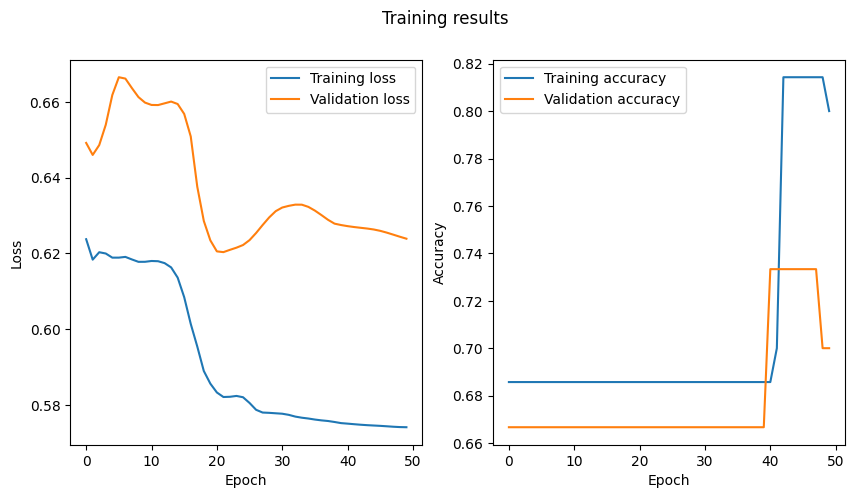

In [40]:
fig, ax1 = plt.subplots(1,2)

# Plot Training and Validation Loss
ax1[0].plot(training_loss_list, label='Training loss')
ax1[0].plot(validation_loss_list, label='Validation loss')
ax1[0].legend()
ax1[0].set_ylabel('Loss')
ax1[0].set_xlabel('Epoch')

# Plot Training and Validation Accuracy
ax1[1].plot(training_acc_list, label='Training accuracy')
ax1[1].plot(validation_acc_list, label='Validation accuracy')
ax1[1].legend()
ax1[1].set_ylabel('Accuracy')
ax1[1].set_xlabel('Epoch')


fig.suptitle('Training results')
fig.set_size_inches(10, 5)